In [ ]:
import os, copy, glob, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#-------------------
import torch
import torch.nn as nn
from torch.optim import Adam
#-------------------
import poseigen_seaside.basics as se
import poseigen_seaside.visuals as viz
import poseigen_compass as co
import poseigen_binmeths as bm
import poseigen_trident.utils as tu
import poseigen_oyster as oys

In [ ]:
mainfolder = se.NewFolder('yy1_data')
fin_bins = se.PickleLoad(mainfolder + 'fin_bins')

divset = ['Train', 'Stop.', ' Eval', 'Test']

xpsfolder = se.NewFolder('xps4')                            #1111111111111111111111111111111

10


In [4]:
exact_folder = se.NewFolder('Oyster')
exact_iter = 11
pn_RO_exact = se.NewFolder(exact_folder + 'RO_' + str(exact_iter))
pn_RO_exact_top = se.NewFolder(pn_RO_exact + 'Top' + str(0))
exact_ranked_can_dict = se.PickleLoad(pn_RO_exact + 'ranked_can_dict')

exact_dict = exact_ranked_can_dict[0]

In [5]:
yy1_split_transaug = se.PickleLoad(mainfolder + 'yy1_split_transaug')

yy1_max = se.PickleLoad(mainfolder + 'yy1_max')

tri_tpacks = se.PickleLoad(mainfolder + 'tri_tpacks')

d_x1, d_y_ms, d_s, d_b, d_x2 = tri_tpacks

d_s_rs = np.swapaxes(np.expand_dims(d_s, axis = -1), 1, -1)

In [6]:
histones = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K9ac', 
            'H3K4me2', 'H4K20me1', 'H2AFZ', 'H3K79me2']

In [7]:
xp6_trial = 2
xp6_id = 'xp6' + '_' + str(xp6_trial) 
pn_xp6 = se.NewFolder(xpsfolder + xp6_id)
pn_xpF, icof, icom = pn_xp6, 0, 3

pn_t1 = se.NewFolder(pn_xpF + str(icof))
pn_t2 = se.NewFolder(pn_t1 + str(icom))

ex_ens_idx = se.PickleLoad(pn_t2 + 'ensemble_idx')

ex_ens_pn_preds, ex_ens_pn_mods = [[pn_t2 + '0_' + str(ir) + s 
                                    for ir in ex_ens_idx]
                                   for s in ['_preds.p',  '_Mod.pt']]

# Sequence Contributions

In [ ]:
not_test = np.delete(np.arange(len(d_x1)), yy1_split_transaug[-1])

d_b_nt = d_b[not_test].reshape(-1)

#-------------------------------------

# nuc_contrib = np.mean(np.array([tu.FeatExtract(mo, 'OysterA', [d_x1, d_x2], batchsize = 512) 
#                                 for mo in ex_ens_pn_mods]), 
#                                 axis = 0)

# se.PickleDump(nuc_contrib, pn_xpF + 'nuc_contrib')

# #-------------------------------------

# sigs_contrib = oys.SigContrib(ex_ens_pn_mods, d_x2, sub_model = 'OysterB')

# se.PickleDump(sigs_contrib, pn_xpF + 'sigs_contrib')

In [10]:
nuc_contrib = se.PickleLoad(pn_xpF + 'nuc_contrib')
nuc_contrib_abs = np.abs(nuc_contrib)
nuc_contrib_nt = nuc_contrib_abs[not_test]

sigs_contrib = se.PickleLoad(pn_xpF + 'sigs_contrib')
sigs_contrib_abs = np.abs(sigs_contrib)
sigs_contrib_nt = sigs_contrib_abs[not_test]

#--------------------------------------------------

comb_contrib_abs = np.concatenate([nuc_contrib_nt.reshape(-1, 1), 
                               sigs_contrib_nt], axis = 1)

comb_contrib_abs_sumd = np.sum(comb_contrib_abs, axis = 1, keepdims=True)

comb_influ = comb_contrib_abs / comb_contrib_abs_sumd

comb_influ_bind = [comb_influ[d_b_nt == b] for b in np.arange(fin_bins)]
comb_influ_bind_mean = np.array([np.mean(x, axis = 0) for x in comb_influ_bind]).T

comb_influ_bind_mean.shape

#-------------------------------------------------

pdx = pd.DataFrame(comb_influ_bind_mean)
pdx.index = ['DNA'] + histones
pdx.columns = np.arange(fin_bins) + 1

pdx['Mean'] = np.mean(comb_influ_bind_mean, axis = -1)

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Greys', axis = None, 
                                                            vmin = 0, vmax = 1)
pdx_sty

,1,2,3,4,5,6,7,8,9,10,Mean
DNA,0.304,0.483,0.494,0.500,0.534,0.544,0.582,0.602,0.659,0.708,0.541
H3K4me3,0.111,0.027,0.013,0.009,0.006,0.003,0.002,0.000,0.001,0.000,0.017
H3K27ac,0.016,0.068,0.076,0.079,0.076,0.079,0.084,0.078,0.064,0.060,0.068
H3K27me3,0.006,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001
H3K4me1,0.133,0.111,0.138,0.149,0.140,0.155,0.133,0.130,0.114,0.094,0.130
H3K36me3,0.007,0.007,0.006,0.005,0.005,0.005,0.005,0.004,0.004,0.003,0.005
H3K9me3,0.021,0.018,0.016,0.014,0.014,0.011,0.009,0.009,0.008,0.007,0.013
H3K9ac,0.006,0.036,0.052,0.060,0.060,0.060,0.058,0.065,0.050,0.043,0.049
H3K4me2,0.057,0.019,0.010,0.006,0.005,0.002,0.002,0.001,0.001,0.001,0.010
H4K20me1,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.000,0.001


In [20]:
refi_combs = [pdx.index[pdx['Mean'] > thre].to_list() for thre in [0, 0.025, 0.05, 0.1, 0.2]]

refi_combs

[['DNA',
  'H3K4me3',
  'H3K27ac',
  'H3K27me3',
  'H3K4me1',
  'H3K36me3',
  'H3K9me3',
  'H3K9ac',
  'H3K4me2',
  'H4K20me1',
  'H2AFZ',
  'H3K79me2'],
 ['DNA', 'H3K27ac', 'H3K4me1', 'H3K9ac', 'H2AFZ', 'H3K79me2'],
 ['DNA', 'H3K27ac', 'H3K4me1', 'H2AFZ', 'H3K79me2'],
 ['DNA', 'H3K4me1'],
 ['DNA']]

# xpHIS

In [22]:
masterpseudo = 1e-10

RMS_mode = [tu.MeanExpo, {'expo': 2, 'root': True}]
RMS_mode_pyt = [tu.MeanExpo, {'expo': 2, 'root': True, 'pyt': True}]

bm_args_np = {'byaxis': 1, 'useweights': False, 'seperate': False, 
              'summarize_mode': RMS_mode}

bm_args_pyt = {'byaxis': 1, 'useweights': False, 'seperate': False, 
               'summarize_mode': RMS_mode_pyt, 'pyt': True}

#------------------------------------------------

deverr_args_base = {'expo': 2, 'root': True, 
                    'pseudo': masterpseudo,
                    'scalefactor': yy1_max}

RMSDE_mode_np = [tu.DeviaError, {**deverr_args_base, 'pyt': False}]
RMSDE_mode_pyt = [tu.DeviaError, {**deverr_args_base, 'pyt': True}]  

B_RMSDE_mode_np = [tu.BinnedLoss, {'metrics_mode': RMSDE_mode_np, **bm_args_np}]
B_RMSDE_mode_pyt = [tu.BinnedLoss, {'metrics_mode': RMSDE_mode_pyt, **bm_args_pyt}]

In [23]:
flipo = [[-2, -1], [-2, -1]]

TT_base =  {
    'inps': [d_x1, d_x2], 'out': d_y_ms, 
    'out_std': d_s_rs, 'out_bind': d_b,
    'Split': yy1_split_transaug,   
    'EUS': None, 'obs_weight': None,                    #!@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    
    'metrics_mode': B_RMSDE_mode_np, 'smallest': True,
    'opt': Adam, 'maxepochs': 100, 
    'patience': 8, 'pickup': True,
    'flips': flipo, 'indivflips': True}

TCS_base = {'trainer': tu.TridentTrainer, 
                 'smallest': None,
                 'get_predictions': True, 'pred_rewrite': False, 
                 'add_pred_args': {'batchsize': 512, 'flips': flipo, 'avg_flips': True},
                 'score_on': 1, 'score_only': False} ### SCORING ON THE EVAL SET, MAKING ONMLY PREDS FOR IT. 

TCR_repeats = 10

TCR_base = {'Splits': None, 'repeats': TCR_repeats,
               'pickup': False, 'savemodels': True, 'returnmodel': True}

#--------------------------------------------------------------------------

es_args = {'out': d_y_ms, 'out_std': d_s_rs, 'out_bind': d_b,
            'split': yy1_split_transaug,
            'metrics_mode': B_RMSDE_mode_np, 
            'score_on': 1,
            'std_cutoff': None, 'ddof': 1, 'top': 3, 'smallest': True}

In [ ]:
def XpsCopy(cur_pn, cur_xp_id, 
            past_xp_id, past_unit, 
            rewrite = False):
                         
    basetargo = cur_pn.replace(cur_xp_id, past_xp_id)[:-2] + str(past_unit) + '/'

    targnames = glob.glob(basetargo + '*')
    lbt = len(basetargo)

    targnames1 = [t for t in targnames if '.p' in t or '.pt' in t]
    newnames1 = [cur_pn + t[lbt:] for t in targnames1]

    print(targnames1, newnames1)


    if rewrite: 
        for n in newnames1: 
            if os.path.isfile(n): os.remove(n)
    for t,n in zip(targnames1, newnames1): 
        if os.path.isfile(n): break #means we already have it
        shutil.copyfile(t, n)

    targnames2 = [t for t in targnames if '.p' not in t and'.pt' not in t]
    newnames2 = [cur_pn + t[lbt:] for t in targnames2]
    if rewrite: 
        for n in newnames2: 
            if os.path.isdir(n): shutil.rmtree(n)
    for t, n in zip(targnames2, newnames2): 
        if os.path.isdir(n): break #means we already have it             
        shutil.copytree(t, n, dirs_exist_ok=True)
    
    print(f'finished copying for {cur_pn}')
    
    return

def XpsBootstrapEnsemb(combs, pathname, rewrite = False):

    iterx = 100

    boots_scores, boots_idxs = [], []

    for icom, com in combs: 
        pn_t = se.NewFolder(pathname + str(icom))

        pn_preds = [pn_t + '0_' + str(ir) + '_Preds' + '.p' ###################
                    for ir in range(TCR_repeats)]
        
        pn_e = pn_t + 'boots_ensemb'

        if os.path.isfile(pn_e + '.p') and rewrite is False: 
            boots_ensemb = se.PickleLoad(pn_e)

        else: 
            boots_ensemb = co.Bootstrapper(pn_preds, mode = [co.EnsembleScorer, es_args],
                                          iters = iterx, updates = 20, return_idx = True)
            se.PickleDump(boots_ensemb, pn_t + 'boots_ensemb')
        
        boots_scores.append(boots_ensemb[0])
        boots_idxs.append(boots_ensemb[1])

        print(f'---- Finished {icom} ----')
    
    return np.array(boots_scores), np.array(boots_idxs)

def XpsResults(pn_xp, xp_combs,
               icof_only = None, 
               configs = None,
               ref_ic = 0, rewrite = False): 
    
    pf_args = {'mode1': [se.RelativeChange, {'perc': True}]}

    bs_all = []
    bs_all_r2r = []

    if configs is None: configs = {0: {}}

    for icof, (cof_name, cof) in enumerate(configs.items()):

        if icof_only is not None: 
            if icof not in icof_only: continue 
                            
        pn_t1 = se.NewFolder(pn_xp + str(icof))

        boots_scores = XpsBootstrapEnsemb(xp_combs, pn_t1, rewrite = rewrite)[0] # Just get scores 

        bs_all.append(boots_scores)

        com = boots_scores[ref_ic]

        rel2refs = [se.PairwiseFuncer(boots_scores[ic], com, **pf_args) for ic, c in xp_combs]

        bs_all_r2r.append(rel2refs)

        print(f'**** Finished {icof} ****')
                    
    bs_all = np.stack(bs_all)
    se.PickleDump(bs_all, pn_xp + 'bs_all')

    bs_all_r2r = np.stack(bs_all_r2r)
    se.PickleDump(bs_all_r2r, pn_xp + 'bs_all_r2r' + '_' + str(ref_ic))

    return bs_all, bs_all_r2r

def XpsTables(pn_xp, xp_combs, xp_variables, ber2rs, icof_only = None, configs = None):

    if configs is None: configs = {0: {}}
    
    onesided = None
    conf_alpha = 0.90

    print(ber2rs.shape)

    ber2rs = ber2rs[:, :, :, 2] ####################################

    ber2rs_mean = np.mean(ber2rs, axis = -1)
    ber2rs_se = np.std(ber2rs, axis = -1)
    ber2rs_low, ber2rs_high = co.BootstrapConfidenceInterval(ber2rs, alpha = conf_alpha, onesided=onesided, axis = -1)

    def sigo(low, high): 
        if onesided == 'lesser': sigi = 0 > high
        if onesided == 'greater': sigi = low > 0 
        if onesided == None: sigi = np.logical_or(0 > high, low > 0)
        return sigi
    
    ber2rs_sigo = sigo(ber2rs_low, ber2rs_high)

    #################################################

    per = pd.DataFrame(ber2rs_mean).T

    if len(xp_variables) > 1: 
        # per.index = pd.MultiIndex.from_tuples([tuple(x[1]) for x in cur_combs], names=cur_variables)
        per.index = [tuple(x[1]) for x in xp_combs]
        per.index.names = ['Combination']
    else: 
        per.index = [tuple(x[1][0]) for x in xp_combs]
        per.index.names = xp_variables
    
    if len(xp_combs[0][1]) > 1: 
        multcolx = pd.MultiIndex.from_tuples([tuple(g[1]) for g in xp_combs])
    else: multcolx = [str(g[1][0]) for g in xp_combs]
    
    configos = list(configs.keys())
    if icof_only is not None: configos = [cz for icz, cz in enumerate(configos) if icz in icof_only]

    per.columns = configos

    per_style = per.style.format(precision=1).background_gradient(axis = 1, vmin = -25, vmax = 0, cmap = 'Greys_r')


    per_style = per_style.apply(lambda _: 
                                np.where(ber2rs_sigo.reshape(-1, len(multcolx)).T, 
                                         'font-weight: bold', ''),
                                           axis = None)

    # #################################################

    ber2rs_stats = np.stack([ber2rs_mean, ber2rs_se, ber2rs_low, ber2rs_high, ber2rs_sigo], axis = -1)

    ber2rs_stats_tidy = [[co, ic, *c, *ber2rs_stats[ico, ic]]
                        for ico, co in enumerate(configos)
                        for ic, c in xp_combs]

    tups_data = [('Models', '', '')]

    tups_var = [*[('Unit', 'Subject',x) for x in ['ID'] + xp_variables]]

    tups_stand = [('Stat', 'Mean', ''), ('Stat', 'SE', ''),
                  ('Stat', 'Percentile', '5th'), ('Stat', 'Percentile', '95th'),
                  ('Stat', 'Percentile', 'Sig.')]

    tups_all = [*tups_data, *tups_var, *tups_stand]

    pdx = pd.DataFrame(ber2rs_stats_tidy)
    multcol = pd.MultiIndex.from_tuples(tups_all)
    pdx.columns = multcol

    pdx[('Stat', 'Percentile', 'Sig.')] = pdx[('Stat', 'Percentile', 'Sig.')].astype('bool')

    def boldo(x): 
            if x[('Stat', 'Percentile', 'Sig.')] == True: 
                return ['font-weight: bold'] * len(x) 
            else: return [''] * len(x)

    pdx = pdx.sort_values([('Models', '', ''), ('Unit', 'Subject', 'ID')])

    pdx_style = pdx.style.format(precision=4).apply(boldo, axis = 1).background_gradient(axis = 1, 
                                                                                         vmin = -25, vmax = 0, 
                                                                                         subset = [('Stat', 'Mean', '')], 
                                                                                         cmap = 'Greys_r')

    return per, per_style, pdx, pdx_style

In [25]:
xpHIS_trial = 4
xpHIS_id = 'xpHIS' + '_' + str(xpHIS_trial) 
pn_xpHIS = se.NewFolder(xpsfolder + xpHIS_id)

xpHIS_variables = ['HisCombs']

hiscombs = refi_combs
hiscombs_nodna = [[h for h in hx if h != 'DNA'] for hx in hiscombs]
hiscombs_nodna_idx = [[histones.index(h) for h in hx] for hx in hiscombs_nodna]

xpHIS_combs = [[ic, [c]] for ic,c in enumerate(hiscombs_nodna_idx)]
xpHIS_combs

[[0, [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]],
 [1, [[1, 3, 6, 9, 10]]],
 [2, [[1, 3, 9, 10]]],
 [3, [[3]]],
 [4, [[]]]]

In [ ]:
modo = oys.DualOyster
duds_mode = [oys.Reset_DualOyster, {}]

lmo, lbx = RMSDE_mode_pyt, False
sampweimode = [bm.BinWeighter, {'uni': np.arange(fin_bins), 'byaxis': None, 
                                    'minus': False, 'newrange': True}]
usxo = 0.2                                                                          #!!!!!!!!!!!!!!!!!!!!!!

xpHIS_TT_args = {'duds_mode': duds_mode, 'duds': TCR_repeats,
                'loss_mode': lmo, 'loss_bind': lbx,
                'weights_mode': sampweimode, 'weights_bind': True,          
                **TT_base}

xpHIS_TT_args.update({'EUS': usxo, 'obs_weight': d_b.reshape(-1)})

xpHIS_TCS_args = {'trainer_args': xpHIS_TT_args, **TCS_base}


xpHIS_rewrite = False

for icof in np.arange(1):                                   # PLACEHOLDER

    for icom, com in xpHIS_combs:

        pn_t1 = se.NewFolder(pn_xpHIS + str(icof))
        pn_t2 = se.NewFolder(pn_t1 + str(icom))

        par_xp, par_unit = None, None

        if icom == 0: par_xp, par_unit = xp6_id, 3                                  #!!!!!!!!!!!!!!!!!!!!!!

        print(par_xp, par_unit)

        if par_unit is not None: 
            XpsCopy(cur_pn = pn_t2, cur_xp_id = xpHIS_id, 
                    past_xp_id = par_xp, past_unit = par_unit, 
                    rewrite = xpHIS_rewrite)
        
        xpHIS_TCR_args = {**xpHIS_TCS_args, **TCR_base, 'pathname': pn_t2}

        #-------------------------------------------

        qox = com[0]

        print(qox)
        
        cof = copy.deepcopy(exact_dict)
        cof.update({'B_incl_only': qox})

        _, _= tu.TridentCanRepeater(modo, cof, data = None, **xpHIS_TCR_args)

In [26]:
xpHIS_bs_all, xpHIS_bs_r2r_all = XpsResults(pn_xpHIS, xpHIS_combs, ref_ic = 0, rewrite = False)

xpHIS_tab_main, xpHIS_tab_main_sty, xpHIS_tab_extra, xpHIS_tab_extra_sty = XpsTables(pn_xpHIS, xpHIS_combs, 
                                                                                   xpHIS_variables, 
                                                                                   xpHIS_bs_r2r_all)

xpHIS_tab_main_sty 

---- Finished 0 ----
---- Finished 1 ----
---- Finished 2 ----
---- Finished 3 ----
---- Finished 4 ----
**** Finished 0 ****
(1, 5, 10000, 4)


,0
HisCombs,
"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)",0.1
"(1, 3, 6, 9, 10)",-0.5
"(1, 3, 9, 10)",0.3
"(3,)",19.6
(),27.8


In [27]:
xpHIS_tab_extra_sty

## Final Performance

In [28]:
cof = copy.deepcopy(exact_dict)
cof.update({'B_incl_only': hiscombs_nodna_idx[2]})


oys.DualOyster(**{k:v for k,v in cof.items() if k not in ['batchsize', 'learningrate']})

(4, 40, 1)


DualOyster(
  (OysterA): Oyster(
    (Reflect): Identity()
    (kE): Sequential(
      (0): Conv2d(1, 31, kernel_size=(7, 4), stride=(1, 1), padding=valid)
      (1): BatchNorm2d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(31, 65, kernel_size=(7, 1), stride=(1, 1), padding=valid)
      (4): BatchNorm2d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(65, 105, kernel_size=(3, 1), stride=(1, 1), padding=valid)
      (7): BatchNorm2d(105, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv2d(105, 150, kernel_size=(1, 1), stride=(1, 1), padding=valid)
      (10): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
    )
    (AntiReflect): Identity()
    (P): AvgPool2d(kernel_size=(50, 1), stride=(50, 1), padding=(7, 0))
    (O): Sequential(
      (0): Dropout2d(p=0.2, inplace=False)
 

In [29]:
pn_xpF, icof, icom = pn_xpHIS, 0, 2

pn_t1 = se.NewFolder(pn_xpF + str(icof))
pn_t2 = se.NewFolder(pn_t1 + str(icom))

ex_pn_preds = [pn_t2 + '0_' + str(ir) + '_Preds.p' 
                  for ir in range(TCR_repeats)]

#-----------------------------------------------------

_ = co.EnsembleScorer(ex_pn_preds, **es_args,
                   pathname = pn_t2, return_extra = False)

ex_ens_idx = se.PickleLoad(pn_t2 + 'ensemble_idx')
print(ex_ens_idx)

ex_ens_pn_preds, ex_ens_pn_mods = [[pn_t2 + '0_' + str(ir) + s 
                                    for ir in ex_ens_idx]
                                   for s in ['_preds.p',  '_Mod.pt']]

ex_ens_preds = np.stack([se.PickleLoad(p) for p in ex_ens_pn_preds]).mean(0)

[0 1 2]


0.2748


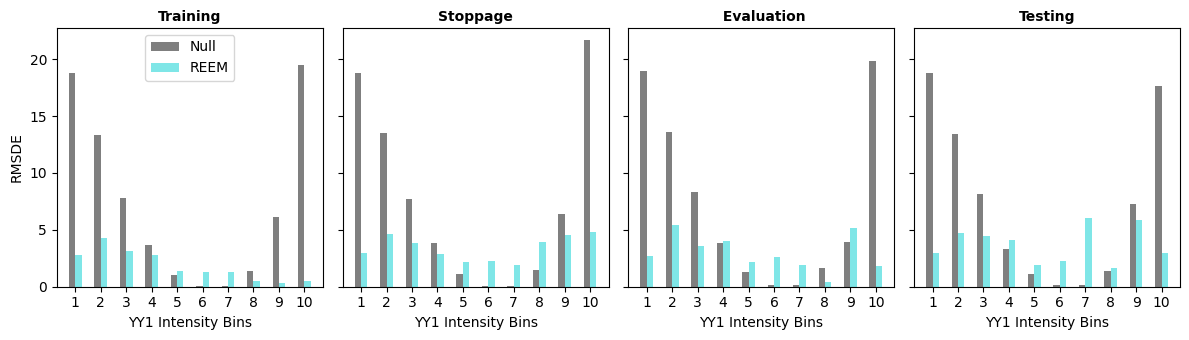

In [31]:
BM_args = {'metrics_mode': RMSDE_mode_np, 'summarize_mode': None}

ex_ens_BM = np.array([tu.BinnedLoss(ex_ens_preds[O], d_y_ms[O],
                        std = d_s_rs[O], bind = d_b[O].reshape(-1),
                        **BM_args) for O in yy1_split_transaug])

#----------------------------------------------------

nullo = se.PickleLoad(mainfolder + 'nullo')

print(nullo)

nullo_BM = np.array([tu.BinnedLoss(np.full(d_y_ms[O].shape, nullo), 
                                   d_y_ms[O],
                        std = d_s_rs[O], bind = d_b[O].reshape(-1),
                        **BM_args) for O in yy1_split_transaug])

#-----------------------------------------------------

comb_BM = np.concatenate([nullo_BM, ex_ens_BM], axis = 1) 

comb_BM_red = [[np.arange(fin_bins) + 1, comb_BM[io]] for io in np.arange(len(yy1_split_transaug))]

#-----------------------------------------------------



divset = ['Training', 'Stoppage', ' Evaluation', 'Testing']

mp_args = {'multi': True, 'paired': False, 'transpose': True, 
           'columntitle': divset,
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (12, 3.5), 'fontsize': 10,
           'sharey': True, 'sharex': True}

bp_args = {'xlabel': 'YY1 Intensity Bins',
            'labelheight': False, 'alpha': 0.5, 
            'group': ['Null', 'REEM'], 'color': ['black', 'darkturquoise'], 
            'width': 0.25}

mp_args = {'multi': True, 'paired': False, 'transpose': True, 
           'columntitle': divset,
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (12, 3.5), 'fontsize': 10,
           'sharey': True, 'sharex': True}

viz.MultiPlot(comb_BM_red, **mp_args,  
          plt_mode = [viz.BarPlot, bp_args], 
          indiv_args = {'legend': [True, False, False, False], 
                        'ylabel': ['RMSDE', None, None, None]});

In [90]:
not_test = np.delete(np.arange(len(d_x1)), yy1_split_transaug[-1])

d_b_nt = d_b[not_test].reshape(-1)

# #-------------------------------------

# nuc_contrib = np.mean(np.array([tu.FeatExtract(mo, 'OysterA', [d_x1, d_x2], batchsize = 512) 
#                                 for mo in ex_ens_pn_mods]), 
#                                 axis = 0)

# se.PickleDump(nuc_contrib, pn_xpF + 'nuc_contrib')

# #-------------------------------------

# sigs_contrib = Oys_SigContrib(ex_ens_pn_mods, d_x2[:, [1, 3, 9, 10]],
#                               sub_model = 'OysterB')

# se.PickleDump(sigs_contrib, pn_xpF + 'sigs_contrib')

In [34]:
nuc_contrib = se.PickleLoad(pn_xpF + 'nuc_contrib')
nuc_contrib_abs = np.abs(nuc_contrib)
nuc_contrib_nt = nuc_contrib_abs[not_test]

nuc_contrib_bind = [nuc_contrib_nt[d_b_nt == b] for b in np.arange(fin_bins)]
nuc_contrib_means = np.array([np.mean(x) for x in nuc_contrib_bind]).reshape(1, -1)
nuc_contrib_std = np.array([np.std(x) for x in nuc_contrib_bind]).reshape(1, -1)

In [35]:
sigs_contrib = se.PickleLoad(pn_xpF + 'sigs_contrib')
sigs_contrib_abs = np.abs(sigs_contrib)
sigs_contrib_nt = sigs_contrib_abs[not_test]

sigs_contrib_bind = [sigs_contrib_nt[d_b_nt == b] for b in np.arange(fin_bins)]
sigs_contrib_means = np.array([np.mean(x, axis = 0) for x in sigs_contrib_bind]).T
sigs_contrib_stds = np.array([np.std(x, axis = 0) for x in sigs_contrib_bind]).T

In [37]:
all_contrib_means = np.vstack([nuc_contrib_means, sigs_contrib_means ])
all_contrib_maxs = all_contrib_means.max(1)

comb_contrib_nt = np.hstack([nuc_contrib_nt.reshape(-1, 1), sigs_contrib_nt])


In [39]:
comb_bind = [comb_contrib_nt[d_b_nt == b] for b in np.arange(fin_bins)]
comb_means = np.array([np.mean(x, axis = 0) for x in comb_bind]).T

# influ_thresh = 0.2

# def boldo(x): 
#         return ['font-weight: bold' if y >= influ_thresh else '' for y in x]

pdx = pd.DataFrame(comb_means)
pdx.index = ['DNA'] + [h for ih, h in enumerate(histones) if ih in [1, 3, 9, 10]]
pdx.columns = np.arange(fin_bins) + 1

pdx['Mean'] = np.mean(comb_means, axis = -1)

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Greys', axis = None, 
                                                            vmin = 0, vmax = 1)
pdx_sty

,1,2,3,4,5,6,7,8,9,10,Mean
DNA,0.032,0.077,0.099,0.122,0.142,0.170,0.211,0.252,0.320,0.431,0.186
H3K27ac,0.019,0.031,0.038,0.043,0.044,0.049,0.055,0.060,0.054,0.062,0.046
H3K4me1,0.012,0.014,0.021,0.025,0.026,0.033,0.033,0.036,0.036,0.037,0.027
H2AFZ,0.010,0.013,0.016,0.017,0.018,0.020,0.021,0.020,0.021,0.027,0.018
H3K79me2,0.001,0.004,0.005,0.006,0.006,0.007,0.008,0.009,0.008,0.008,0.006


In [38]:
comb_contrib_tot = comb_contrib_nt.sum(-1).reshape(-1, 1)
comb_contrib_scaled = comb_contrib_nt / comb_contrib_tot

comb_bind = [comb_contrib_scaled[d_b_nt == b] for b in np.arange(fin_bins)]
comb_means = np.array([np.mean(x, axis = 0) for x in comb_bind]).T

# influ_thresh = 0.2

# def boldo(x): 
#         return ['font-weight: bold' if y >= influ_thresh else '' for y in x]

pdx = pd.DataFrame(comb_means)
pdx.index = ['DNA'] + [h for ih, h in enumerate(histones) if ih in [1, 3, 9, 10]]
pdx.columns = np.arange(fin_bins) + 1

pdx['Mean'] = np.mean(comb_means, axis = -1)

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Greys', axis = None, 
                                                            vmin = 0, vmax = 1)
pdx_sty

,1,2,3,4,5,6,7,8,9,10,Mean
DNA,0.365,0.533,0.541,0.554,0.589,0.594,0.628,0.654,0.711,0.756,0.593
H3K27ac,0.288,0.237,0.224,0.209,0.191,0.181,0.177,0.167,0.131,0.114,0.192
H3K4me1,0.166,0.098,0.115,0.121,0.112,0.124,0.102,0.100,0.086,0.066,0.109
H2AFZ,0.157,0.104,0.094,0.086,0.081,0.074,0.068,0.055,0.052,0.049,0.082
H3K79me2,0.024,0.027,0.027,0.029,0.026,0.027,0.024,0.025,0.020,0.015,0.024


# CORRELATION

In [ ]:
hisos = np.swapaxes(d_x2, 0, 1).reshape(len(histones), -1)

his_corrs = []
for ih1, h1 in enumerate(histones): 
    for ih2, h2 in enumerate(histones): 
        
        if h1 != h2: 
            cor = se.Correlation(hisos[ih1], hisos[ih2]) ** 2
            if cor > 0.7 or cor < -0.7 : print(f'{h1, h2, cor}')

('H3K4me3', 'H3K9ac', np.float64(0.8034583769156313))
('H3K4me3', 'H3K4me2', np.float64(0.8536944659484123))
('H3K27ac', 'H3K9ac', np.float64(0.7214973909036585))
('H3K9ac', 'H3K4me3', np.float64(0.8034583769156313))
('H3K9ac', 'H3K27ac', np.float64(0.7214973909036585))
('H3K9ac', 'H3K4me2', np.float64(0.7007811703625939))
('H3K4me2', 'H3K4me3', np.float64(0.8536944659484123))
('H3K4me2', 'H3K9ac', np.float64(0.7007811703625939))


In [68]:
hisos.shape

(11, 2400000)

In [94]:
d_x2_nt = d_x2[not_test]

hisos_nt = np.swapaxes(d_x2_nt, 0, 1).reshape(len(histones), -1)

his_corrs = se.PairwiseFuncer(hisos_nt, hisos_nt, mode1 = [se.Correlation, {}])

his_corrs = np.array(his_corrs).reshape(len(histones), -1)

his_r2 = his_corrs ** 2

In [95]:
pdx = pd.DataFrame(his_corrs, columns=histones, index=histones)

def boldo(x):
    return['font-weight: bold' if u > 0.7 else '' for u in x]

pdx_sty = pdx.style.format(precision=2).apply(boldo, axis = 1).background_gradient(axis = None, 
                                                                                   vmin = 0, vmax = 1,
                                                                                     cmap = 'Greys')

pdx_sty

,H3K4me3,H3K27ac,H3K27me3,H3K4me1,H3K36me3,H3K9me3,H3K9ac,H3K4me2,H4K20me1,H2AFZ,H3K79me2
H3K4me3,1.00,0.71,-0.08,0.07,0.04,0.00,0.90,0.93,0.16,0.54,0.58
H3K27ac,0.71,1.00,-0.08,0.29,0.05,0.02,0.85,0.75,0.05,0.52,0.33
H3K27me3,-0.08,-0.08,1.00,-0.11,-0.09,0.10,-0.08,-0.07,0.18,-0.08,-0.09
H3K4me1,0.07,0.29,-0.11,1.00,0.15,0.07,0.10,0.20,0.14,0.32,0.10
H3K36me3,0.04,0.05,-0.09,0.15,1.00,0.17,0.04,0.06,0.36,-0.14,0.33
H3K9me3,0.00,0.02,0.10,0.07,0.17,1.00,-0.01,0.01,0.04,0.04,0.03
H3K9ac,0.90,0.85,-0.08,0.10,0.04,-0.01,1.00,0.84,0.10,0.51,0.53
H3K4me2,0.93,0.75,-0.07,0.20,0.06,0.01,0.84,1.00,0.17,0.59,0.52
H4K20me1,0.16,0.05,0.18,0.14,0.36,0.04,0.10,0.17,1.00,-0.12,0.43
H2AFZ,0.54,0.52,-0.08,0.32,-0.14,0.04,0.51,0.59,-0.12,1.00,0.00
